In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE

In [129]:
#extract processed data
df = pd.read_csv("processed_data.csv")

#remove extreme high correlation varaibles and unrelated variables 
df.drop(['ANNMILES', 'GASUSGE'], axis=1, inplace=True)

#separate prediction variable and id from dataframe
df_y = df.pop('SuperUser')
id = df.pop("HOUSEID")

#create train and test dataset
x_train, x_test, y_train, y_test = train_test_split(df, df_y, test_size=0.25, random_state=42)


In [130]:
len(x_train.columns)

66

In [131]:
y_train.value_counts()

SuperUser
0    4845
1     529
Name: count, dtype: int64

In [132]:
print(y_train.value_counts())

SuperUser
0    4845
1     529
Name: count, dtype: int64


In [133]:
x = pd.concat([x_train, y_train], axis=1)
non_superuser = x[x.SuperUser == 0]
superuser = x[x.SuperUser == 1]
superuser_upsampled = resample(superuser, replace=True, n_samples = len(non_superuser), random_state=42)
upsampled = pd.concat([non_superuser,superuser_upsampled])
up_y_train = upsampled.SuperUser
up_x_train = upsampled.drop('SuperUser', axis=1)
up_y_train.value_counts()


SuperUser
0    4845
1    4845
Name: count, dtype: int64

In [134]:
non_superuser_downsampled = resample(non_superuser, replace = False, n_samples = len(superuser), random_state=42)
downsampled = pd.concat([non_superuser_downsampled, superuser])
d_y_train = downsampled.SuperUser
d_x_train = downsampled.drop('SuperUser', axis=1)
d_y_train.value_counts()

SuperUser
0    529
1    529
Name: count, dtype: int64

In [135]:
smote = SMOTE()
s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

Due to data being imbalanced in nonsuperuser vs superuser, KNN is not suited

In [172]:
knn = KNeighborsClassifier(n_neighbors=5)
#knn.fit(x_train, y_train)
#knn.fit(up_x_train, up_y_train)
knn.fit(d_x_train, d_y_train)

y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print('Confusion matrix')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))


Accuracy: 57.03%
ROCAUC: 53.46%
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.58      0.71      1604
           1       0.12      0.49      0.19       188

    accuracy                           0.57      1792
   macro avg       0.51      0.53      0.45      1792
weighted avg       0.82      0.57      0.65      1792

Confusion matrix
     0    1
0  930  674
1   96   92


In [176]:
#"""
rfc = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=10, min_samples_split =10,
                             max_features=None,
                             class_weight={0:0.1, 1:0.9}
)
#"""

rfc.fit(x_train, y_train)
#rfc.fit(up_x_train, up_y_train)
#rfc.fit(s_x_train, s_y_train)
#rfc.fit(d_x_train, d_y_train)


test_pred = rfc.predict(d_x_train)
y_pred = rfc.predict(x_test)

print("Train data accuracy report:")
accuracy = accuracy_score(d_y_train, test_pred)
roc_score = roc_auc_score(d_y_train, test_pred)
class_report = classification_report(d_y_train, test_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print(pd.DataFrame(confusion_matrix(d_y_train, test_pred)), '\n')


print("Test data accuracy report:")
accuracy = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))

Train data accuracy report:
Accuracy: 93.67%
ROCAUC: 93.67%
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       529
           1       0.97      0.90      0.93       529

    accuracy                           0.94      1058
   macro avg       0.94      0.94      0.94      1058
weighted avg       0.94      0.94      0.94      1058

     0    1
0  513   16
1   51  478 

Test data accuracy report:
Accuracy: 86.83%
ROCAUC: 53.90%
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      1604
           1       0.24      0.12      0.16       188

    accuracy                           0.87      1792
   macro avg       0.57      0.54      0.55      1792
weighted avg       0.83      0.87      0.85      1792

      0   1
0  1533  71
1   165  23


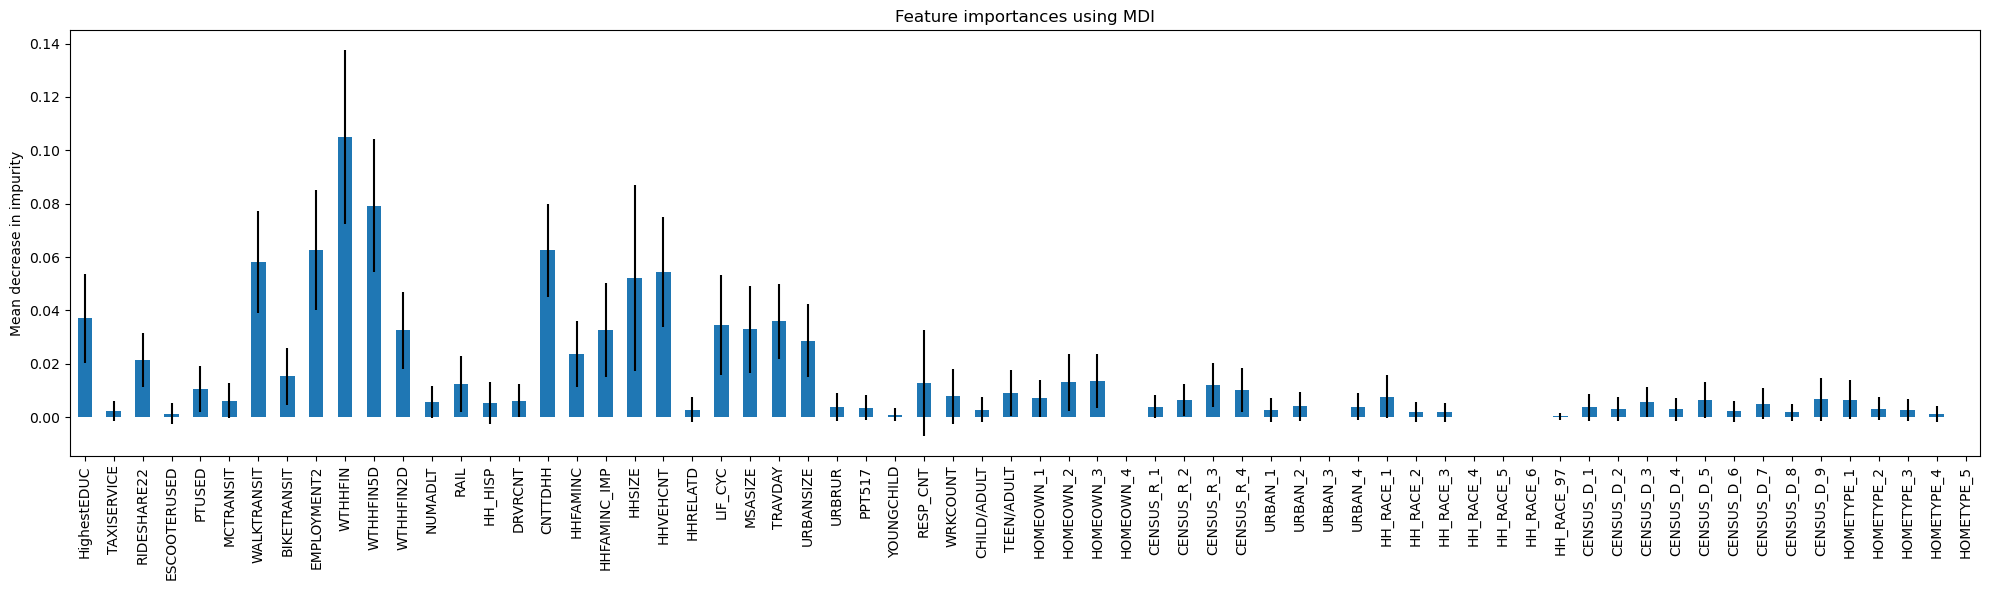

In [177]:
importances = pd.Series(rfc.feature_importances_, index=rfc.feature_names_in_)
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

forest_importances = pd.Series(importances, index=rfc.feature_names_in_)
fig, ax = plt.subplots(figsize=(20,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


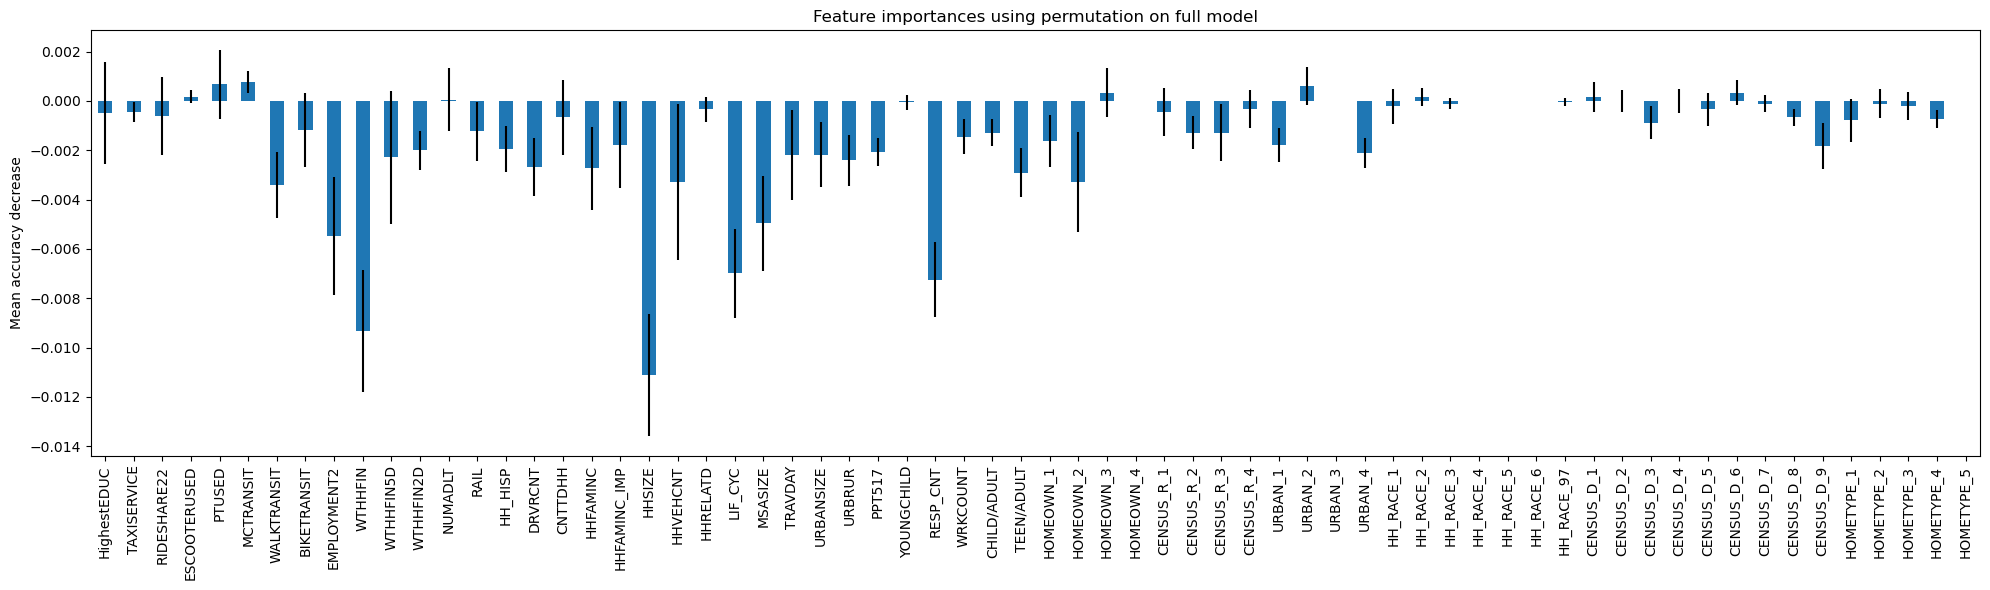

In [178]:
result = permutation_importance(
    rfc, x_test, y_test, n_repeats=10, random_state=None, n_jobs=None
)
forest_importances = pd.Series(result.importances_mean, index=rfc.feature_names_in_)

fig, ax = plt.subplots(figsize=(20,6))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()